In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import warnings
# Ignore PerformanceWarnings specifically
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=Warning)  # Ignore Perform

In [2]:
file_path = "/kaggle/input/data-storm-6-0/sample_submission_storming_round.csv" 
sub = pd.read_csv(file_path)

In [3]:
file_path = "/kaggle/input/data-storm-6-0/train_storming_round.csv" 
train = pd.read_csv(file_path)

In [4]:
file_path = "/kaggle/input/data-storm-6-0/test_storming_round.csv" 
test = pd.read_csv(file_path)

In [5]:
train

,row_id,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,1,455ca878,45,2/1/2021,9/1/2023,1/1/2023,3,6,2,12,...,9,3,4,8,15,0,0,93313,30,162
1,2,c823ce77,48,4/1/2022,2/1/2024,1/1/2023,1,4,12,21,...,14,4,3,10,17,25,1071450,164804,0,175
2,3,62154055,53,5/1/2020,9/1/2023,1/1/2023,3,5,5,17,...,14,3,7,11,21,26,1601210,426690,84,78
3,4,c58bfa6e,44,7/1/2019,3/1/2022,1/1/2023,1,0,12,17,...,11,2,2,9,13,18,283230,47793,39,144
4,5,b1e5f770,20,9/1/2020,2/1/2023,1/1/2023,0,6,10,17,...,13,3,10,6,19,20,1957680,562239,19,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15303,15304,d3b44e44,43,4/1/2019,10/1/2023,8/1/2024,1,6,6,17,...,10,3,4,11,18,25,2473900,404980,18,100
15304,15305,0b1d7054,28,9/1/2022,3/1/2024,8/1/2024,1,5,3,13,...,14,4,3,11,18,15,922050,198187,18,120
15305,15306,51321fa2,45,1/1/2021,4/1/2024,8/1/2024,0,6,17,26,...,22,6,7,6,19,30,645330,133263,57,270
15306,15307,dd4a0d2d,25,12/1/2021,12/1/2023,8/1/2024,0,4,6,14,...,13,6,3,6,15,0,0,32546,30,171


In [6]:
ids = test['row_id']
train = train.drop(columns=['row_id'], axis=1)
test = test.drop(columns=['row_id'], axis=1)

In [7]:
train['year_month'] = pd.to_datetime(train['year_month'], format='%m/%d/%Y')
test['year_month'] = pd.to_datetime(test['year_month'], format='%m/%d/%Y')
train['agent_join_month'] = pd.to_datetime(train['agent_join_month'], format='%m/%d/%Y')
test['agent_join_month'] = pd.to_datetime(test['agent_join_month'], format='%m/%d/%Y')
train['first_policy_sold_month'] = pd.to_datetime(train['first_policy_sold_month'], format='%m/%d/%Y')
test['first_policy_sold_month'] = pd.to_datetime(test['first_policy_sold_month'], format='%m/%d/%Y')

In [8]:
train_sorted = train.sort_values(by=['agent_code', 'year_month']).copy()

In [9]:
train_sorted = train_sorted.reset_index()

In [11]:
train_sorted.head(60)

,index,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,...,unique_quotations,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies
0,8,003c1999,35,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,...,2,2,2,1,5,0,0,327407,5,0
1,958,003c1999,35,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,...,14,2,5,12,19,31,2408297,408662,57,217
2,1761,003c1999,35,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,...,19,4,5,11,20,27,1901097,287226,20,243
3,2577,003c1999,35,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,...,19,4,9,7,20,22,1635788,381203,60,176
4,2708,003c1999,35,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,...,14,4,6,8,18,20,1876640,471548,0,180
5,3978,003c1999,35,2020-08-01,2022-12-01,2023-06-01,0,3,4,12,...,15,2,4,13,19,0,0,44510,38,0
6,4704,003c1999,35,2020-08-01,2022-12-01,2023-07-01,3,0,2,10,...,8,3,2,6,11,14,114828,26501,33,126
7,5258,003c1999,35,2020-08-01,2022-12-01,2023-08-01,3,5,9,18,...,15,2,6,8,16,26,2310698,282573,32,0
8,6039,003c1999,35,2020-08-01,2022-12-01,2023-09-01,2,6,14,26,...,16,1,7,8,16,35,2413530,403629,0,140
9,6635,003c1999,35,2020-08-01,2022-12-01,2023-10-01,3,2,20,28,...,24,2,2,11,15,35,2186835,561881,45,0


In [12]:
train_shifted = train_sorted.copy()
train_shifted['next_month_new_policy_count'] = train_shifted.groupby('agent_code')['new_policy_count'].shift(-1)

In [13]:
last_rows = train_shifted.groupby('agent_code').tail(1)
train_shifted = train_shifted.drop(last_rows.index)

In [14]:
train_shifted.head(60)

,index,agent_code,agent_age,agent_join_month,first_policy_sold_month,year_month,unique_proposals_last_7_days,unique_proposals_last_15_days,unique_proposals_last_21_days,unique_proposal,...,unique_customers_last_7_days,unique_customers_last_15_days,unique_customers_last_21_days,unique_customers,new_policy_count,ANBP_value,net_income,number_of_policy_holders,number_of_cash_payment_policies,next_month_new_policy_count
0,8,003c1999,35,2020-08-01,2022-12-01,2023-01-01,2,2,0,8,...,2,2,1,5,0,0,327407,5,0,31.0
1,958,003c1999,35,2020-08-01,2022-12-01,2023-02-01,3,2,20,30,...,2,5,12,19,31,2408297,408662,57,217,27.0
2,1761,003c1999,35,2020-08-01,2022-12-01,2023-03-01,0,2,19,23,...,4,5,11,20,27,1901097,287226,20,243,22.0
3,2577,003c1999,35,2020-08-01,2022-12-01,2023-04-01,2,6,11,21,...,4,9,7,20,22,1635788,381203,60,176,20.0
4,2708,003c1999,35,2020-08-01,2022-12-01,2023-05-01,3,3,7,15,...,4,6,8,18,20,1876640,471548,0,180,0.0
5,3978,003c1999,35,2020-08-01,2022-12-01,2023-06-01,0,3,4,12,...,2,4,13,19,0,0,44510,38,0,14.0
6,4704,003c1999,35,2020-08-01,2022-12-01,2023-07-01,3,0,2,10,...,3,2,6,11,14,114828,26501,33,126,26.0
7,5258,003c1999,35,2020-08-01,2022-12-01,2023-08-01,3,5,9,18,...,2,6,8,16,26,2310698,282573,32,0,35.0
8,6039,003c1999,35,2020-08-01,2022-12-01,2023-09-01,2,6,14,26,...,1,7,8,16,35,2413530,403629,0,140,35.0
9,6635,003c1999,35,2020-08-01,2022-12-01,2023-10-01,3,2,20,28,...,2,2,11,15,35,2186835,561881,45,0,21.0


In [15]:
train_shifted = train_shifted.drop(columns=['index'])

In [16]:
train_shifted['proposals_trend'] = train_shifted['unique_proposals_last_7_days'] - train_shifted['unique_proposals_last_15_days']
train_shifted['quotations_trend'] = train_shifted['unique_quotations_last_7_days'] - train_shifted['unique_quotations_last_15_days']
train_shifted['customers_trend'] = train_shifted['unique_customers_last_7_days'] - train_shifted['unique_customers_last_15_days']

In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_shifted['agent_code'] = le.fit_transform(train_shifted['agent_code'])

In [20]:
train_shifted['agent_join_year'] = train_shifted['agent_join_month'].dt.year
train_shifted['agent_join_month_num'] = train_shifted['agent_join_month'].dt.month

train_shifted['first_policy_sold_year'] = train_shifted['first_policy_sold_month'].dt.year
train_shifted['first_policy_sold_month_num'] = train_shifted['first_policy_sold_month'].dt.month

train_shifted['year'] = train_shifted['year_month'].dt.year
train_shifted['month'] = train_shifted['year_month'].dt.month

# Drop original datetime columns
train_shifted = train_shifted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [21]:
cols_to_normalize = [
    'unique_proposals_last_7_days',
    'unique_proposal',
    'unique_quotations_last_7_days',
    'unique_quotations',
    'unique_customers_last_7_days',
    'unique_customers',
    'number_of_cash_payment_policies',
    'number_of_policy_holders',
    'net_income'
]

# Group by year and month, calculate sum for each group
group_cols = ['year', 'month']
grouped_sum = train_shifted.groupby(group_cols)[cols_to_normalize].transform('sum')

# Divide each value by the total in its (year, month) group
for col in cols_to_normalize:
    train_shifted[col + '_proportion'] = train_shifted[col] / grouped_sum[col]

In [22]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    # Filter out scores that are 0 or below
    scores = scores[scores > 0].sort_values(ascending=True)
    
    # Plotting
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(8, 6))
    plt.barh(width, scores, color='steelblue')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores (MI > 0)")
    plt.xlabel("MI Score")
    plt.tight_layout()
    plt.show()

In [24]:
train_sorted['agent_code'] = le.fit_transform(train_sorted['agent_code'])

In [25]:
train_sorted['agent_join_year'] = train_sorted['agent_join_month'].dt.year
train_sorted['agent_join_month_num'] = train_sorted['agent_join_month'].dt.month

train_sorted['first_policy_sold_year'] = train_sorted['first_policy_sold_month'].dt.year
train_sorted['first_policy_sold_month_num'] = train_sorted['first_policy_sold_month'].dt.month

train_sorted['year'] = train_sorted['year_month'].dt.year
train_sorted['month'] = train_sorted['year_month'].dt.month

# Drop original datetime columns
train_sorted = train_sorted.drop(columns=['agent_join_month', 'first_policy_sold_month', 'year_month'])

In [26]:
train_sorted = train_sorted.drop(columns=['index'])

number_of_cash_payment_policies    2.202927
unique_proposal                    1.047793
unique_proposals_last_21_days      0.566619
ANBP_value                         0.537956
unique_quotations                  0.201898
net_income                         0.133629
unique_proposals_last_15_days      0.057398
unique_proposals_last_7_days       0.010219
agent_code                         0.009937
unique_quotations_last_7_days      0.008091
first_policy_sold_month_num        0.007916
agent_join_year                    0.007244
month                              0.002928
unique_quotations_last_15_days     0.002101
unique_quotations_last_21_days     0.000719
unique_customers                   0.000000
agent_age                          0.000000
unique_customers_last_15_days      0.000000
number_of_policy_holders           0.000000
unique_customers_last_7_days       0.000000
agent_join_month_num               0.000000
first_policy_sold_year             0.000000
year                            

<Figure size 800x500 with 0 Axes>

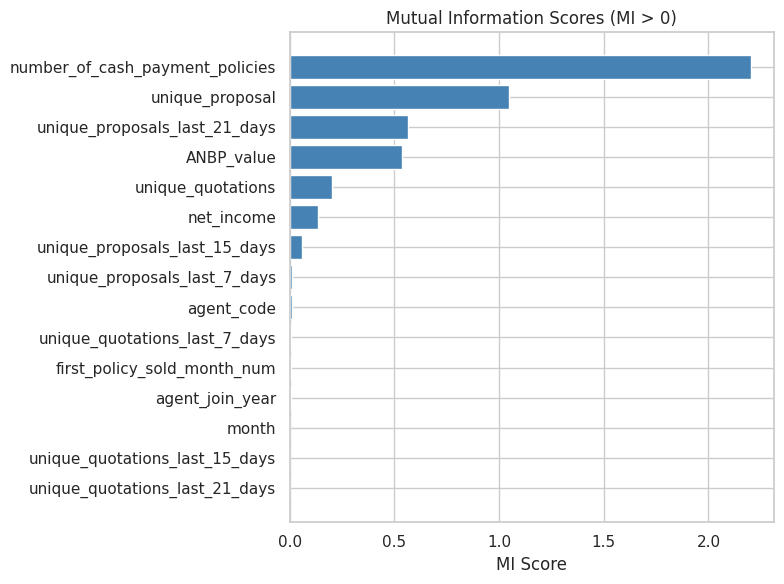

In [47]:
X = train_sorted.drop(columns=['new_policy_count'], axis=1)
y = train_sorted['new_policy_count']

mi_scores = make_mi_scores(X, y)
X = train_sorted.drop(columns=['new_policy_count'], axis=1)
y = train_sorted['new_policy_count']

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [29]:
train_shifted['next_month_new_policy_count'] = (train_shifted['next_month_new_policy_count'] != 0).astype(int)

In [30]:
agents_with_all_ones = (
    train_shifted.groupby('agent_code')['next_month_new_policy_count']
    .apply(lambda x: (x == 1).all())
)

# Filter only those agents
agents_with_all_ones = agents_with_all_ones[agents_with_all_ones].index.tolist()
agents_with_all_ones = set(agents_with_all_ones)
len(agents_with_all_ones)

200

In [31]:
train_shifted['past_nill'] = train_shifted['agent_code'].isin(agents_with_all_ones).astype(int)

In [33]:
train_shifted['join_duration'] = (train_shifted['year'] - train_shifted['agent_join_year'])*12 + (train_shifted['month'] - train_shifted['agent_join_month_num'])
train_shifted['time_to_sell'] = (train_shifted['first_policy_sold_year'] - train_shifted['agent_join_year'])*12 + (train_shifted['first_policy_sold_month_num'] - train_shifted['agent_join_month_num'])

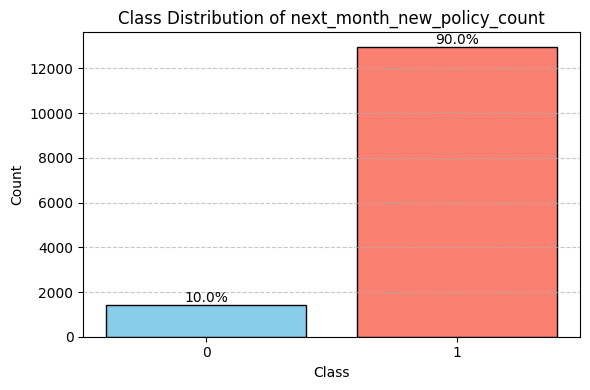

In [34]:
class_counts = train_shifted['next_month_new_policy_count'].value_counts().sort_index()
class_percentages = class_counts / class_counts.sum() * 100

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(class_counts.index.astype(str), class_counts, color=['skyblue', 'salmon'], edgecolor='black')

# Add percentages on top of bars
for bar, percentage in zip(bars, class_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{percentage:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Class Distribution of next_month_new_policy_count')
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

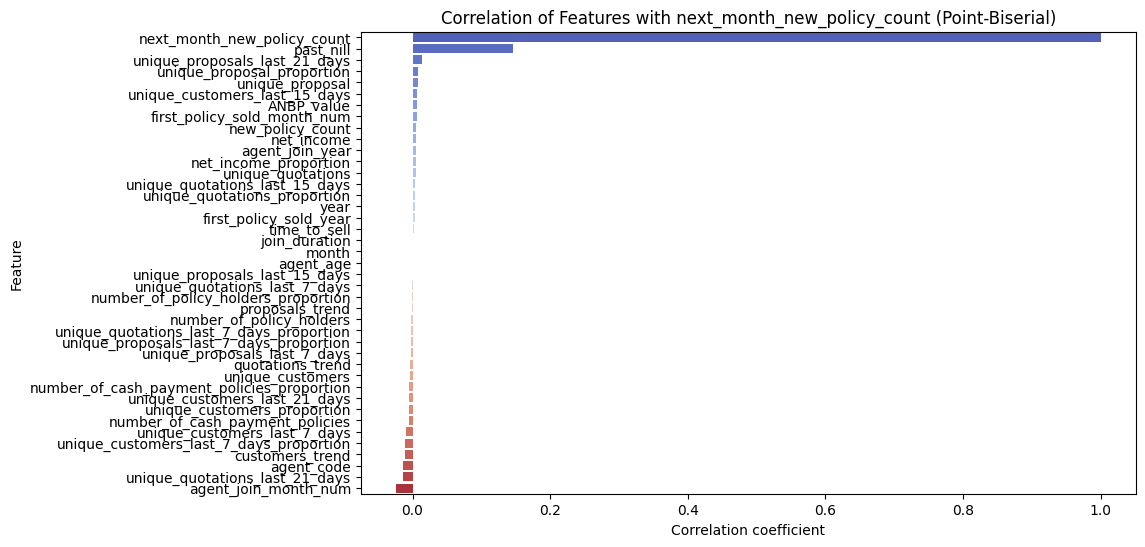

In [35]:
# Compute correlation of all features with the target only
target_corr = train_shifted.corr(method='pearson')['next_month_new_policy_count'].sort_values(ascending=False)

# Plot as bar plot instead of heatmap (cleaner)
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.values, y=target_corr.index, palette='coolwarm')
plt.title("Correlation of Features with next_month_new_policy_count (Point-Biserial)")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

net_income                                    2.901777
ANBP_value                                    0.534811
agent_code                                    0.140950
number_of_cash_payment_policies               0.027280
past_nill                                     0.022706
agent_join_month_num                          0.014970
unique_quotations                             0.014128
new_policy_count                              0.013778
unique_proposals_last_7_days_proportion       0.007011
agent_age                                     0.005892
number_of_policy_holders                      0.005814
unique_quotations_last_7_days                 0.005399
unique_customers                              0.005125
unique_customers_last_21_days                 0.004629
time_to_sell                                  0.004562
unique_quotations_last_7_days_proportion      0.003974
join_duration                                 0.003947
unique_quotations_last_21_days                0.002832
unique_pro

<Figure size 800x500 with 0 Axes>

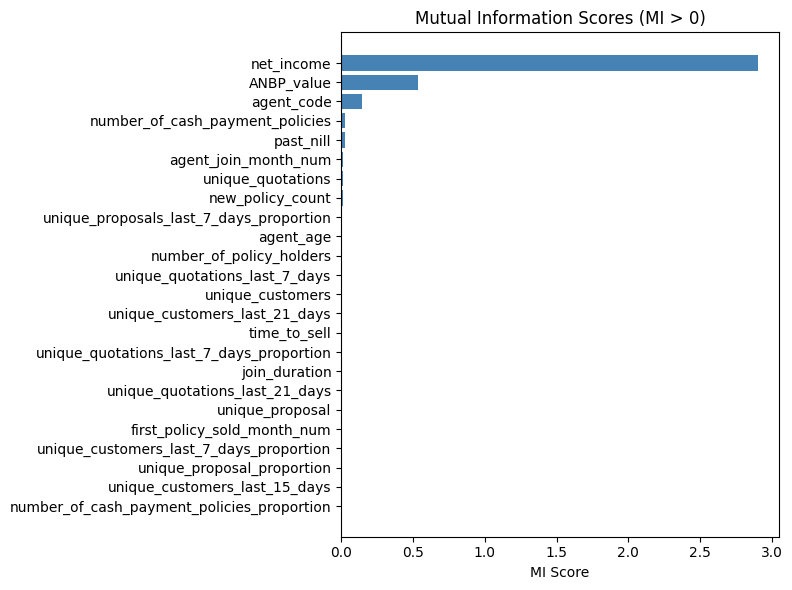

In [36]:
X = train_shifted.drop(columns=['next_month_new_policy_count'], axis=1)
y = train_shifted['next_month_new_policy_count']

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  

In [39]:
train_shifted.columns

Index(['agent_code', 'agent_age', 'unique_proposals_last_7_days',
       'unique_proposals_last_15_days', 'unique_proposals_last_21_days',
       'unique_proposal', 'unique_quotations_last_7_days',
       'unique_quotations_last_15_days', 'unique_quotations_last_21_days',
       'unique_quotations', 'unique_customers_last_7_days',
       'unique_customers_last_15_days', 'unique_customers_last_21_days',
       'unique_customers', 'new_policy_count', 'ANBP_value', 'net_income',
       'number_of_policy_holders', 'number_of_cash_payment_policies',
       'next_month_new_policy_count', 'proposals_trend', 'quotations_trend',
       'customers_trend', 'agent_join_year', 'agent_join_month_num',
       'first_policy_sold_year', 'first_policy_sold_month_num', 'year',
       'month', 'unique_proposals_last_7_days_proportion',
       'unique_proposal_proportion',
       'unique_quotations_last_7_days_proportion',
       'unique_quotations_proportion',
       'unique_customers_last_7_days_proporti

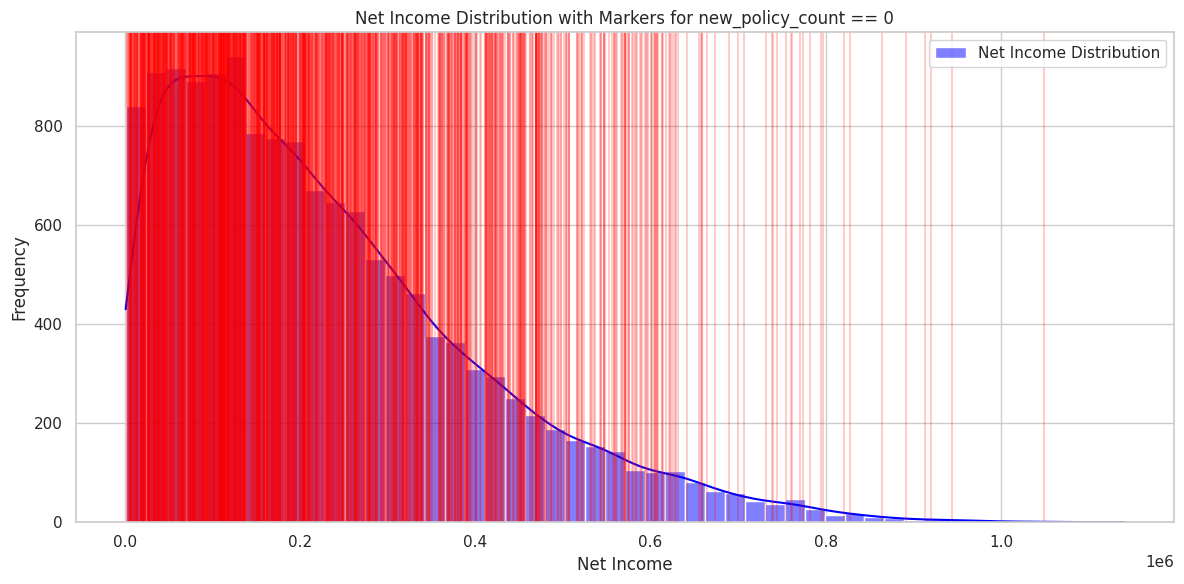

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot distribution of net_income
plt.figure(figsize=(12, 6))
sns.histplot(train_shifted['net_income'], bins=50, kde=True, color='blue', label='Net Income Distribution')

# Mark positions where new_policy_count is 0
zero_policy_net_incomes = train_shifted[train_shifted['next_month_new_policy_count'] == 0]['net_income']

for income in zero_policy_net_incomes:
    plt.axvline(x=income, color='red', linestyle='-', alpha=0.2)

plt.title('Net Income Distribution with Markers for new_policy_count == 0')
plt.xlabel('Net Income')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

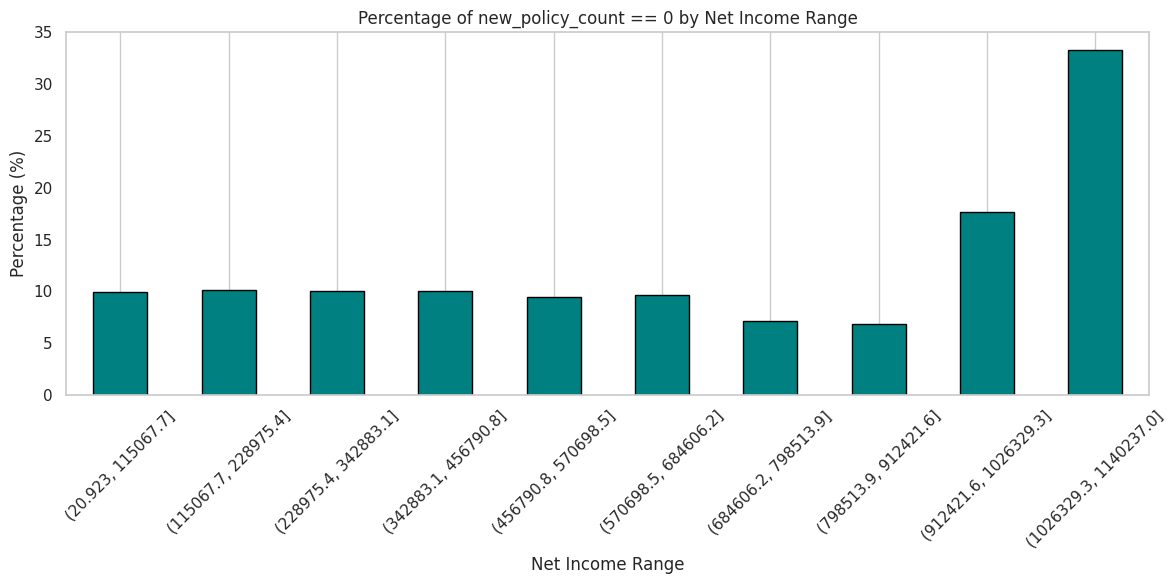

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bins for net_income
bins = pd.cut(train_shifted['net_income'], bins=10)  # You can adjust number of bins as needed

# Calculate percentage of new_policy_count == 0 in each bin
bin_summary = train_shifted.groupby(bins)['next_month_new_policy_count'].apply(lambda x: (x == 0).mean() * 100)

# Plot
plt.figure(figsize=(12, 6))
bin_summary.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Percentage of new_policy_count == 0 by Net Income Range')
plt.xlabel('Net Income Range')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


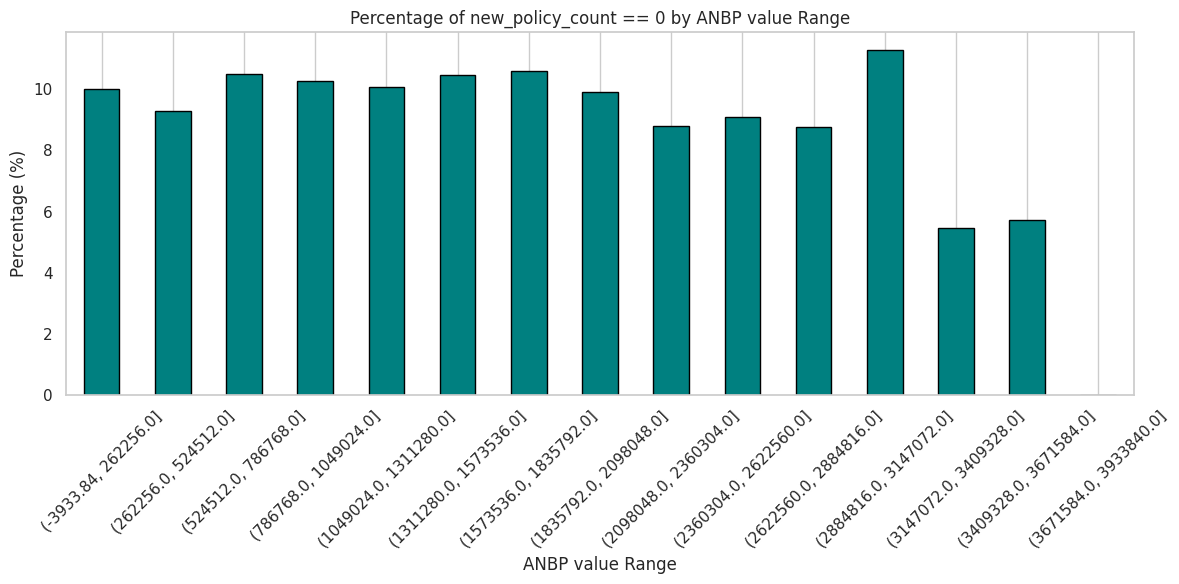

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bins for net_income
bins = pd.cut(train_shifted['ANBP_value'], bins=15)  # You can adjust number of bins as needed

# Calculate percentage of new_policy_count == 0 in each bin
bin_summary = train_shifted.groupby(bins)['next_month_new_policy_count'].apply(lambda x: (x == 0).mean() * 100)

# Plot
plt.figure(figsize=(12, 6))
bin_summary.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Percentage of new_policy_count == 0 by ANBP value Range')
plt.xlabel('ANBP value Range')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

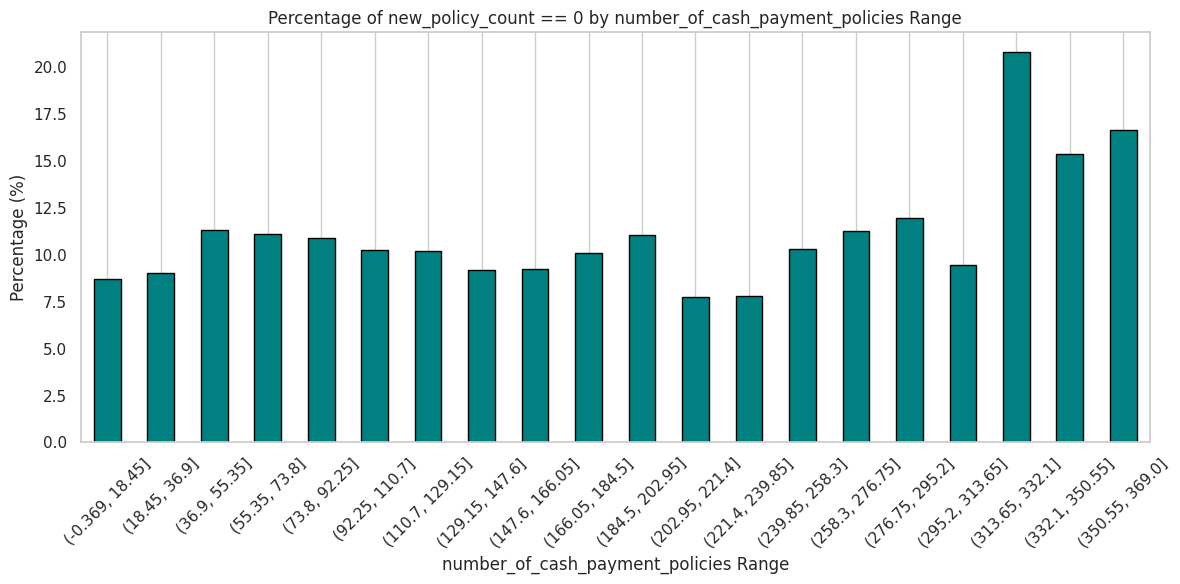

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bins for net_income
bins = pd.cut(train_shifted['number_of_cash_payment_policies'], bins=20)  # You can adjust number of bins as needed

# Calculate percentage of new_policy_count == 0 in each bin
bin_summary = train_shifted.groupby(bins)['next_month_new_policy_count'].apply(lambda x: (x == 0).mean() * 100)

# Plot
plt.figure(figsize=(12, 6))
bin_summary.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Percentage of new_policy_count == 0 by number_of_cash_payment_policies Range')
plt.xlabel('number_of_cash_payment_policies Range')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


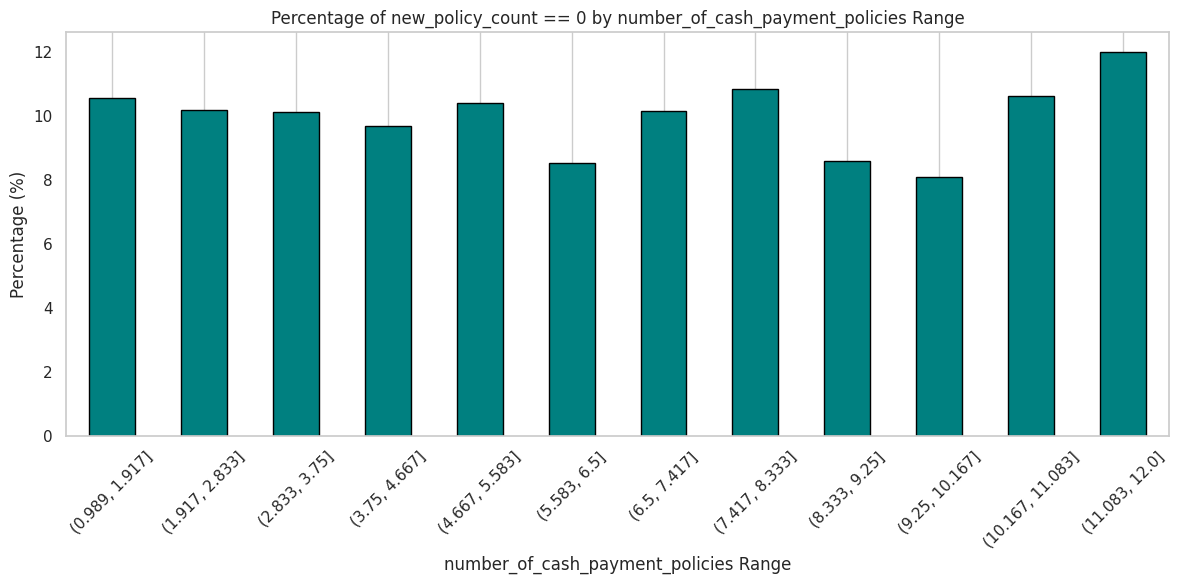

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Create bins for net_income
bins = pd.cut(train_shifted['month'], bins=12)  # You can adjust number of bins as needed

# Calculate percentage of new_policy_count == 0 in each bin
bin_summary = train_shifted.groupby(bins)['next_month_new_policy_count'].apply(lambda x: (x == 0).mean() * 100)

# Plot
plt.figure(figsize=(12, 6))
bin_summary.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Percentage of new_policy_count == 0 by number_of_cash_payment_policies Range')
plt.xlabel('number_of_cash_payment_policies Range')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [46]:
import plotly.graph_objects as go
import plotly.express as px

top_n_professions = 50
profession_counts = train_shifted['agent_code'].value_counts().nlargest(top_n_professions)
filtered_data = train_shifted[train_shifted['agent_code'].isin(profession_counts.index)]

# Create a summary DataFrame
sankey_data = filtered_data.groupby(['agent_code', 'next_month_new_policy_count']).size().reset_index(name='Count')

# Define the source and target for the Sankey chart
labels = list(sankey_data['agent_code'].unique()) + ['NILL', 'Not NILL']
source_indices = []
target_indices = []

for _, row in sankey_data.iterrows():
    profession_index = labels.index(row['agent_code'])
    depression_index = labels.index('Not NILL' if row['next_month_new_policy_count'] == 1 else 'NILL')
    source_indices.append(profession_index)
    target_indices.append(depression_index)

# Create a Sankey chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color='blue'
    ),
    link=dict(
        source=source_indices,  # Indices correspond to labels, e.g., A=0, B=1, C=2...
        target=target_indices,
        value=sankey_data['Count']
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Agent and Nill", 
    font_size=10,
    width=700, 
    height=600)

fig.show()